Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

In [46]:
%%capture

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import LinearRegression as lr, Ridge
from category_encoders import OneHotEncoder

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'


# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [47]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols, parse_dates=['SALE DATE'], index_col='SALE DATE')

    df['BOROUGH'] = df['BOROUGH'].astype(object)
    return df


filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'


**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [48]:
df = wrangle(filepath)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
SALE DATE,,,,,,
2019-01-01,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,1979.0,2007.0,$ - 0
2019-01-01,1,FASHION,21 OFFICE BUILDINGS,15435.0,1920.0,$ - 0
2019-01-01,1,FASHION,21 OFFICE BUILDINGS,11332.0,1930.0,$ - 0
2019-01-01,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,500.0,0.0,$ - 0
2019-01-01,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,6406.0,0.0,$ - 0


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [49]:
def clean_price(price):
    return int(price.split()[-1].replace(',', ''))

df['SALE PRICE'] = df['SALE PRICE'].apply(clean_price)
# modify the wrangle function above

In [50]:
df = df[(df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 2000000)]
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
SALE DATE,,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1872.0,1940.0,620000


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [51]:
X = df.drop(columns='SALE PRICE')
y = df['SALE PRICE']


**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [52]:
training = X.index < pd.to_datetime('3/2019')

X_train, y_train = X[training], y[training]
X_test, y_test = X[~training], y[~training]

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [53]:
baseline_mae_train = mae(y_train, [y_train.mean()] * len(y_train))
baseline_mae_test = mae(y_test, [y_test.mean()] * len(y_test))
print('Baseline MAE:', baseline_mae_train)
print('Baseline MAE:', baseline_mae_test)


Baseline MAE: 214345.38054217925
Baseline MAE: 216677.46655947485


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [54]:
ohe = OneHotEncoder(use_cat_names=True)
ohe.fit(X_train)
XT_train = ohe.transform(X_train);
XT_test = ohe.transform(X_test);


C:\Users\coco\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [55]:
model_lr = lr()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [56]:
model_r = Ridge()
model_r.fit(XT_train, y_train)

Ridge()

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [57]:
training_mae_lr = mae(y_train, model_lr.predict(XT_train))
test_mae_lr = mae(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 123153.37473699136
Linear Test MAE: 94538792980.38568


**Task 10:** Check the training and test metrics for `model_r`.

In [59]:
training_mae_r = mae(y_train, model_r.predict(XT_train))
test_mae_r = mae(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 124909.91476648107
Ridge Test MAE: 136818.9995167867


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [61]:
# Caculate R^2 score
print(model_r.score(XT_train, y_train))
print(model_r.score(XT_test, y_test))


0.6266607578397356
0.5255647424340435


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

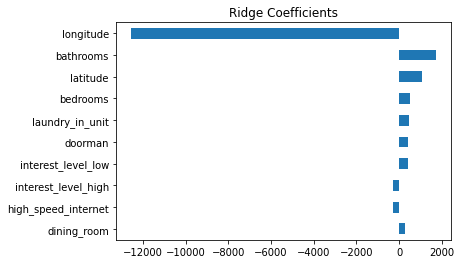

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

<AxesSubplot:>

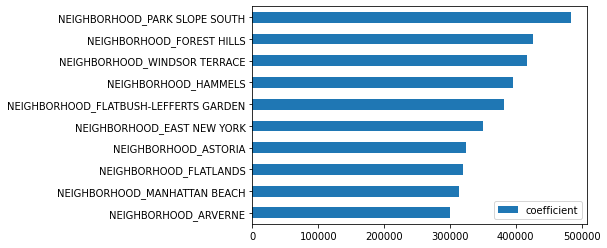

In [67]:
pd.DataFrame(data=model_r.coef_, index=XT_train.columns,
             columns=['coefficient']).abs().sort_values(by='coefficient').tail(10).plot(kind='barh')
